In [1]:
from patsy import dmatrices
from sklearn import linear_model as lm
from sklearn.linear_model import LogisticRegression
from sklearn import model_selection
from sklearn import metrics
from sklearn.metrics import confusion_matrix,recall_score,precision_score
from statsmodels.formula.api import Logit
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn import model_selection
from sklearn import metrics
from sklearn.metrics import confusion_matrix,recall_score,precision_score,f1_score,classification_report
import pandas as pd
import numpy as np
import csv
import itertools
from collections import Counter

In [32]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier

In [55]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

pd.set_option('display.width',5000)

%config InlineBackend.figure_format = 'svg'

#%config InlineBackend.figure_format = 'png'
import matplotlib as mpl
plt.rcParams['figure.dpi']= 300

In [4]:
from patsy import dmatrices

from sklearn import linear_model as lm
from sklearn.linear_model import LogisticRegression
from sklearn import model_selection
from sklearn import metrics
from sklearn.metrics import confusion_matrix,recall_score,precision_score
from sklearn.metrics import classification_report

In [18]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [5]:
df = pd.read_csv('mariners.csv')

In [6]:
df = df[df.pitch_type != 'null']

In [7]:
df = pd.get_dummies(df, columns=["pitch_type"])
df = pd.get_dummies(df, columns=['p_throws'])
df = pd.get_dummies(df, columns=["stand"])
df = pd.get_dummies(df, columns=["outs_when_up"])
df = pd.get_dummies(df, columns=["if_fielding_alignment"])
df = pd.get_dummies(df, columns=["of_fielding_alignment"])
df.rename(columns={'type':'called'}, inplace=True)
df = pd.get_dummies(df, columns=["called"])

In [21]:
df = pd.get_dummies(df, columns=["inning_topbot"])

In [23]:
df.rename(columns={'inning_topbot_Bot':'inning_bot'}, inplace=True)

In [24]:
df.rename(columns={'inning_topbot_Top':'inning_top'}, inplace=True)

In [8]:
df['breaking'] = df['pitch_type_SL'] + df['pitch_type_CU'] + df['pitch_type_KC']
df['offspeed'] = df['pitch_type_CH'] + df['pitch_type_FS']
df['fastball'] = df['pitch_type_FF'] + df['pitch_type_FT'] + df['pitch_type_SI'] + df['pitch_type_FC']

In [9]:
df['on_3b'] = df['on_3b'].replace(['null'], 0)
df['on_2b'] = df['on_2b'].replace(['null'], 0)
df['on_1b'] = df['on_1b'].replace(['null'], 0)
df.on_3b = df.on_3b.astype(int)
df.on_2b = df.on_2b.astype(int)
df.on_1b = df.on_1b.astype(int)

In [11]:
maxVal = 1
df['on_3b'][df['on_3b'] >= maxVal] = maxVal
df['on_2b'][df['on_2b'] >= maxVal] = maxVal
df['on_1b'][df['on_1b'] >= maxVal] = maxVal

/Users/alexanderbell/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/Users/alexanderbell/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/alexanderbell/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the 

In [10]:
conditions = [
    (df['balls'] == 0) & (df['strikes'] == 0),
    (df['balls'] == 0) & (df['strikes'] == 1),
    (df['balls'] == 0) & (df['strikes'] == 2),
    (df['balls'] == 1) & (df['strikes'] == 0),
    (df['balls'] == 1) & (df['strikes'] == 1),
    (df['balls'] == 1) & (df['strikes'] == 2),
    (df['balls'] == 2) & (df['strikes'] == 0),
    (df['balls'] == 2) & (df['strikes'] == 1),
    (df['balls'] == 2) & (df['strikes'] == 2),
    (df['balls'] == 3) & (df['strikes'] == 0),
    (df['balls'] == 3) & (df['strikes'] == 1),
    (df['balls'] == 3) & (df['strikes'] == 2)
]
choices = ['0-0', '0-1', '0-2','1-0','1-1','1-2','2-0','2-1','2-2','3-0','3-1','3-2']
df['count'] = np.select(conditions, choices)
df = pd.get_dummies(df, columns=["count"])

In [12]:
df.rename(columns={'if_fielding_alignment_Infield shift':'if_shift'}, inplace=True)
df.rename(columns={'if_fielding_alignment_Standard':'if_standard'}, inplace=True)
df.rename(columns={'if_fielding_alignment_Strategic':'if_strategic'}, inplace=True)
df.rename(columns={'of_fielding_alignment_4th outfielder':'of_fourth'}, inplace=True)
df.rename(columns={'of_fielding_alignment_Standard':'of_standard'}, inplace=True)
df.rename(columns={'of_fielding_alignment_Strategic':'of_strategic'}, inplace=True)
df.drop('if_fielding_alignment_null',axis=1,inplace=True)
df.drop('of_fielding_alignment_null',axis=1,inplace=True)

In [13]:
df['run_diff'] = df['bat_score'] - df['fld_score']

In [14]:
df['pitch']=0
df['pitch'][df.offspeed == 1] = 2
df['pitch'][df.breaking == 1] = 1

/Users/alexanderbell/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/Users/alexanderbell/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [15]:
df.zone[df.zone == 'null'] = 14
df.zone = df.zone.astype(int)
df.release_speed[df.release_speed == 'null'] = 90
df.release_speed = df.release_speed.astype(float)
df['prev_pitch'] = df['pitch'].shift(-1)
df['prev_pitch'] = df['prev_pitch'].fillna(0)
df['prev_speed'] = df['release_speed'].shift(-1)
df['prev_speed'] = df['prev_speed'].fillna(90)
df['prev_zone'] = df['zone'].shift(-1)
df['prev_zone'] = df['prev_zone'].fillna(13)
df['prev_ball'] = df['called_B'].shift(-1)
df['prev_ball'] = df['prev_ball'].fillna(0)
df['prev_strike'] = df['called_S'].shift(-1)
df['prev_strike'] = df['prev_strike'].fillna(1)

/Users/alexanderbell/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/Users/alexanderbell/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [67]:
df = pd.get_dummies(df, columns=["prev_zone"])

In [68]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23065 entries, 0 to 23082
Data columns (total 85 columns):
game_date          23065 non-null object
release_speed      23065 non-null float64
player_name        23065 non-null object
batter             23065 non-null int64
pitcher            23065 non-null int64
events             23065 non-null object
description        23065 non-null object
zone               23065 non-null int64
home_team          23065 non-null object
away_team          23065 non-null object
balls              23065 non-null int64
strikes            23065 non-null int64
on_3b              23065 non-null int64
on_2b              23065 non-null int64
on_1b              23065 non-null int64
inning             23065 non-null int64
sv_id              23065 non-null object
effective_speed    23065 non-null object
at_bat_number      23065 non-null int64
pitch_number       23065 non-null int64
pitch_name         23065 non-null object
bat_score          23065 non-null int64


In [69]:
df.sample()

,game_date,release_speed,player_name,batter,pitcher,events,description,zone,home_team,away_team,balls,strikes,on_3b,on_2b,on_1b,inning,sv_id,effective_speed,at_bat_number,pitch_number,pitch_name,bat_score,fld_score,pitch_type_CH,pitch_type_CU,pitch_type_FC,pitch_type_FF,pitch_type_FS,pitch_type_FT,pitch_type_KC,pitch_type_PO,pitch_type_SI,pitch_type_SL,p_throws_L,p_throws_R,stand_L,stand_R,outs_when_up_0,outs_when_up_1,outs_when_up_2,if_shift,if_standard,if_strategic,of_fourth,of_standard,of_strategic,called_B,called_S,called_X,breaking,offspeed,fastball,count_0-0,count_0-1,count_0-2,count_1-0,count_1-1,count_1-2,count_2-0,count_2-1,count_2-2,count_3-0,count_3-1,count_3-2,run_diff,pitch,prev_pitch,prev_speed,prev_ball,prev_strike,inning_bot,inning_top,prev_zone_1.0,prev_zone_2.0,prev_zone_3.0,prev_zone_4.0,prev_zone_5.0,prev_zone_6.0,prev_zone_7.0,prev_zone_8.0,prev_zone_9.0,prev_zone_11.0,prev_zone_12.0,prev_zone_13.0,prev_zone_14.0
2234,9/13/18,79.7,Mike Leake,628336,502190,null,called_strike,5,LAA,SEA,0,0,0,0,0,7,180914_043350,77.234,60,1,Knuckle Curve,1,6,0,0,0,0,0,0,1,0,0,0,0,1,1,0,0,0,1,0,1,0,0,1,0,0,1,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,-5,1,0.0,87.2,0.0,0.0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0


{'bootstrap': True,
 'max_depth': 90,
 'max_features': 'sqrt',
 'min_samples_leaf': 4,
 'min_samples_split': 10,
 'n_estimators': 400}

In [134]:
X = df[['balls','strikes','on_3b','on_2b','on_1b','inning','at_bat_number','pitch_number','p_throws_L','stand_L',
        'if_shift','if_strategic','of_fourth','of_strategic','outs_when_up_1','outs_when_up_2',
        'run_diff','prev_pitch','prev_speed','prev_ball','prev_strike','inning_bot','prev_zone_1.0',
        'prev_zone_2.0','prev_zone_3.0','prev_zone_4.0','prev_zone_5.0','prev_zone_6.0','prev_zone_7.0',
        'prev_zone_8.0','prev_zone_9.0','prev_zone_11.0','prev_zone_12.0','prev_zone_13.0','prev_zone_14.0']]

In [135]:
y = df.pitch

In [136]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.2, random_state=42)

In [137]:
RC = RandomForestClassifier(bootstrap=True,max_depth=None,max_features=None,
                            min_samples_leaf=1,min_samples_split=2,n_estimators=2000)

In [138]:
RC = RC.fit(X_train, y_train)

In [139]:
y_pred = RC.predict(X_test)

In [140]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.66      0.86      0.74      2888
           1       0.41      0.21      0.28      1069
           2       0.38      0.17      0.24       656

   micro avg       0.61      0.61      0.61      4613
   macro avg       0.48      0.41      0.42      4613
weighted avg       0.56      0.61      0.57      4613



In [141]:
import pandas as pd
feature_importances = pd.DataFrame(RC.feature_importances_,
                                   index = X_train.columns,
                                    columns=['importance']).sort_values('importance',ascending=False)

In [151]:
feat_imp.to_csv('feat_imp.csv')

In [150]:
feat_imp = feature_importances
feat_imp

,importance
prev_speed,0.197869
at_bat_number,0.148245
run_diff,0.093911
pitch_number,0.048025
inning,0.047092
prev_pitch,0.023374
inning_bot,0.022660
outs_when_up_1,0.021727
on_1b,0.021569
stand_L,0.021382


In [142]:
feature_importances

,importance
prev_speed,0.197869
at_bat_number,0.148245
run_diff,0.093911
pitch_number,0.048025
inning,0.047092
prev_pitch,0.023374
inning_bot,0.022660
outs_when_up_1,0.021727
on_1b,0.021569
stand_L,0.021382


In [143]:
# confusion matrix
confusion_matrix(y_test,y_pred)

array([[2478,  268,  142],
       [ 799,  226,   44],
       [ 488,   54,  114]])

In [144]:
cm = confusion_matrix(y_test,y_pred)
#names = ['1','2','3','4','5','6','7','8','9','11','12','13','14']
names = ['fastball','breaking','offspeed']
title='Confusion matrix'

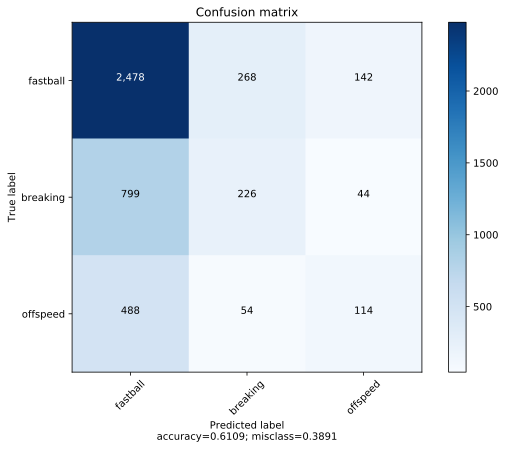

In [145]:
plot_confusion_matrix(cm,names,normalize=False)

In [38]:
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()
    
#    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html    

In [81]:
from sklearn.model_selection import RandomizedSearchCV
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
random_grid

{'bootstrap': [True, False],
 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]}

In [82]:
#Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestClassifier()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 200, cv = 5, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
rf_random.fit(X_train, y_train)

Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
/Users/alexanderbell/anaconda3/lib/python3.6/site-packages/sklearn/externals/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
/Users/alexanderbell/anaconda3/lib/python3.6/site-packages/sklearn/externals/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
/Users/alexanderbell/anaconda3/lib/python3.6/site-packages/sklearn/externals/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory le

RandomizedSearchCV(cv=5, error_score='raise-deprecating',
          estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
          fit_params=None, iid='warn', n_iter=200, n_jobs=-1,
          param_distributions={'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000], 'max_features': ['auto', 'sqrt'], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'bootstrap': [True, False]},
          pre_dispatch='2*n_jobs', random_state=42, refit=True,
          return_train_score='warn', scoring=None, verbose=2)

In [83]:
rf_random.best_params_

{'bootstrap': True,
 'max_depth': 90,
 'max_features': 'sqrt',
 'min_samples_leaf': 4,
 'min_samples_split': 10,
 'n_estimators': 400}

In [146]:
from sklearn.tree import export_graphviz
from sklearn import tree
import graphviz
import pydotplus

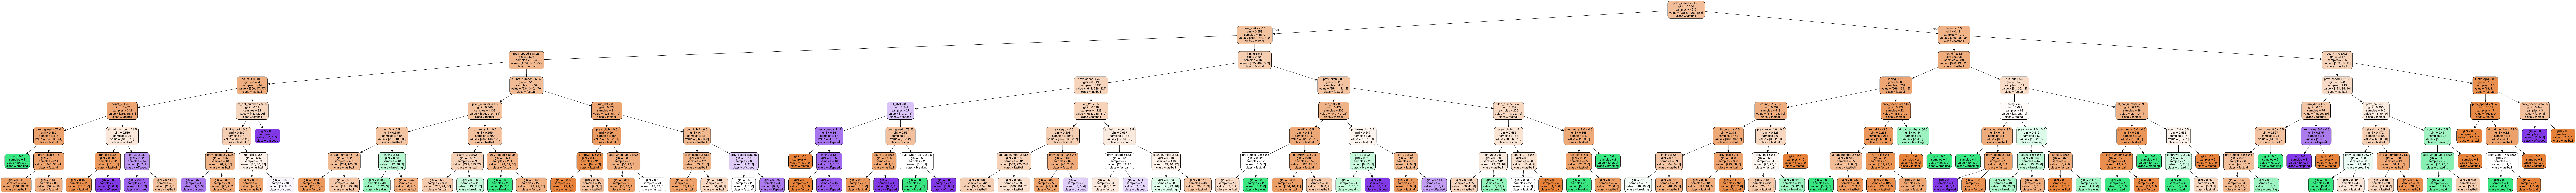

In [148]:
clf = tree.DecisionTreeClassifier(max_depth=7)
clf = clf.fit(X_test, y_test)
dot_data = tree.export_graphviz(clf, out_file=None, 
                         feature_names=X.columns,  
                         class_names = ['fastball','breaking','offspeed'],
                         filled=True, rounded=True,  
                         special_characters=True)  
graph = graphviz.Source(dot_data)  
graph.format = 'svg'
graph.render('dtree_render',view=True)
png_bytes = graph.pipe(format='png')
with open('dtree_pipe.png','wb') as f:
    f.write(png_bytes)

from IPython.display import Image
Image(png_bytes)